Access GridMET data from Microsoft Planetary computer using their Stac API. File is Zarr. Access only the data needed, and the variables needed (precipitation only for now). 

Just realized Microsoft Planetary computer only has data through 2020 for this....

In [ ]:
import pystac_client
import planetary_computer
import xarray as xr

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
time_range = "2025-06-24"
bbox = [-126, 24, -65, 50]

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset


In [ ]:
ds = xr.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"]
)
ds

Pulled the 06/24 file manually from the GridMET site (on 06/25). 

Notes:
* Metadata says that the day runs from midnight to midnight Mountain Standard time. This leads to the differences between this and GFS/PRISM. 
* Could use Pygridmet package to access the data, but it seems like it might be easier to just use the netcdf file. 


In [30]:
import xarray as xr

ds = xr.open_dataset("data/gridmet/pr_2025_gridmet.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 1GB
Dimensions:               (lon: 1386, lat: 585, day: 175, crs: 1)
Coordinates:
  * lon                   (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 5kB 49.4 49.36 49.32 ... 25.11 25.07
  * day                   (day) datetime64[ns] 1kB 2025-01-01 ... 2025-06-24
  * crs                   (crs) uint16 2B 3
Data variables:
    precipitation_amount  (day, lat, lon) float64 1GB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       115
    last_early_slice:           175
    last_provisional_slice:     169
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [31]:
ds_pr_0623 = ds.sel(day='2025-06-23T00:00:00.000000000')
ds_pr_0623['precipitation_amount'].attrs

{'units': 'mm',
 'description': 'Daily Accumulated Precipitation',
 'long_name': 'pr',
 'standard_name': 'pr',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326'}

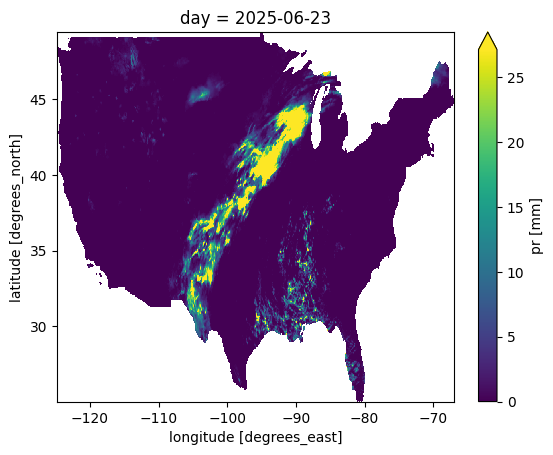

In [32]:
ds_pr_0623['precipitation_amount'].plot(robust=True)

Attempt to download file froom gridmet site using requests. 

In [1]:
import requests

In [2]:
url = "http://www.northwestknowledge.net/metdata/data/pr_2025.nc"

In [3]:
response = requests.get(url, stream=True)

In [4]:
local_filename = "data/gridmet/pr_2025_gridmet.nc"

response.raise_for_status()  # Raise an error for bad status codes
with open(local_filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:  # Skip keep-alive chunks
            f.write(chunk)

In [7]:
import xarray as xr

ds_gridmet = xr.open_dataset("data/gridmet/pr_2025_gridmet.nc", engine="netcdf4")
ds_gridmet

<xarray.Dataset> Size: 1GB
Dimensions:               (lon: 1386, lat: 585, day: 187, crs: 1)
Coordinates:
  * lon                   (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 5kB 49.4 49.36 49.32 ... 25.11 25.07
  * day                   (day) datetime64[ns] 1kB 2025-01-01 ... 2025-07-06
  * crs                   (crs) uint16 2B 3
Data variables:
    precipitation_amount  (day, lat, lon) float64 1GB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       127
    last_early_slice:           187
    last_provisional_slice:     181
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [13]:
ds_gridmet_0623 = ds_gridmet.sel(day='2025-06-23T00:00:00.000000000', method="nearest")
ds_gridmet_0623

<xarray.Dataset> Size: 7MB
Dimensions:               (lon: 1386, lat: 585, crs: 1)
Coordinates:
  * lon                   (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 5kB 49.4 49.36 49.32 ... 25.11 25.07
    day                   datetime64[ns] 8B 2025-06-23
  * crs                   (crs) uint16 2B 3
Data variables:
    precipitation_amount  (lat, lon) float64 6MB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       127
    last_early_slice:           187
    last_provisional_slice:     181
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In production data pull, use method="nearest" to get most recent day (with today - 1 as starting point)

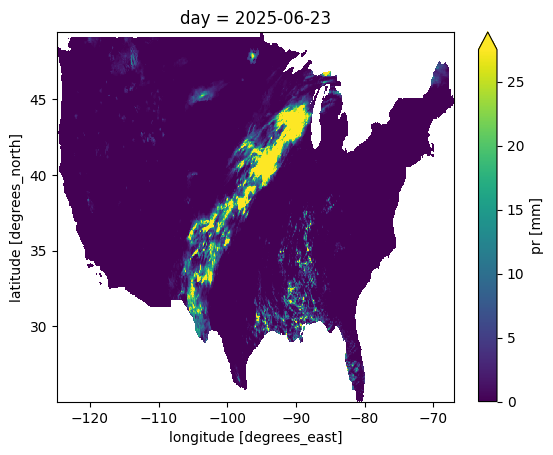

In [14]:
ds_gridmet_0623['precipitation_amount'].plot(robust=True)

In [39]:
import rioxarray as rxr

ds_gridmet_0623.crs

<xarray.DataArray 'crs' ()> Size: 8B
array(0)
Coordinates:
    day      datetime64[ns] 8B 2025-06-23
    crs      int64 8B 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.7666666333333 0.041666666666666 0.0 49...

In [31]:
# Extract GeoTransform values and convert to Affine
from rasterio.transform import Affine

gt_vals = [
    -124.7666666333333,  # origin x
    0.041666666666666,   # pixel width
    0.0,                 # x rotation
    49.400000000000000,  # origin y
    0.0,                 # y rotation
    -0.041666666666666   # pixel height (negative because top-to-bottom)
]

transform = Affine.from_gdal(*gt_vals)

# Assign transform and CRS manually
ds_gridmet_0623 = ds_gridmet_0623.rio.write_transform(transform)
ds_gridmet_0623 = ds_gridmet_0623.rio.write_crs("EPSG:4326")  # GridMET is in lat/lon WGS84

# Now reproject to EPSG:5070 (Albers Equal Area for CONUS)
ds_gridmet_0623_5070 = ds_gridmet_0623.rio.reproject("EPSG:5070")

In [35]:
ds_gridmet_0623_5070 = ds_gridmet_0623_5070['precipitation_amount']

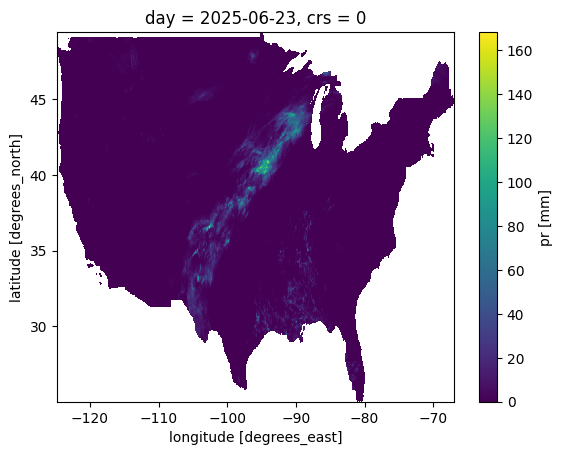

In [38]:
ds_gridmet_0623["precipitation_amount"].plot()

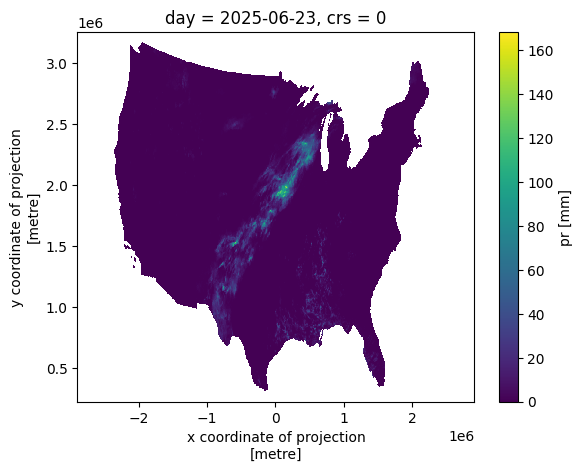

In [36]:
ds_gridmet_0623_5070.plot()

In [37]:
ds_gridmet_0623_5070.to_netcdf("data/gridmet/pr_gridmet_5070_06232025.nc")